In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import PchipInterpolator
import pandas as pd

In [16]:
# -----------------------------
# Curva Cp vs TSR (Patel)
# -----------------------------
Cp_paper = np.flip([0.005, 0.04, 0.19, 0.13, 0.1, 0])
TSR_points = np.flip([1.2, 1, 0.8, 0.6, 0.4, 0])
"""
data = {
    "TSR": [0.8, 0.6, 0.4, 1.0],
    "RPM": [11.1688, 8.3766, 5.5848, 13.9610],
    "cl_mean": [6.488489, 7.012507, 10.937404, 6.261091],
    "cd_mean": [1.673412, 1.622872, 2.381539, 1.595192],
    "cm_mean": [0.161259, 0.165222, 0.275497, 0.135734],
    "Cp_mean": [0.129007, 0.099133, 0.110199, 0.135734]
}
df = pd.DataFrame(data)

#Cp_paper = np.flip([0.005, 0.04, 0.19, 0.13, 0.1, 0])
#TSR_points = np.flip([1.2, 1, 0.8, 0.6, 0.4, 0])
# Sort by TSR
df_sorted = df.sort_values(by="TSR").reset_index(drop=True)

# Extract sorted vectors
TSR_sorted = df_sorted["TSR"].values
Cp_sorted = df_sorted["Cp_mean"].values

TSR_aug = np.append(TSR_sorted, 1.2)
Cp_aug = np.append(Cp_sorted, 0.0)

# Prepend TSR = 0, Cp = 0
TSR_final = np.insert(TSR_aug, 0, 0.0)
Cp_final = np.insert(Cp_aug, 0, 0.0)

Cp_paper=Cp_final
TSR_points = TSR_final

print("Cp_interp(0.8) = ", Cp_interp(1.2))
"""
Cp_interp = PchipInterpolator(TSR_points, Cp_paper)

In [ ]:
def Cp(xq):
    # Cp=@(xq) (xq<1.2 & xq>0).*pchip(TSR,Cp_paper,xq)
    return np.where((xq > 0) & (xq < 1.2), Cp_interp(xq), 0)

xq = np.linspace(0, 1.2, 100)

# -----------------------------
# Parámetros físicos
# -----------------------------
V_air = lambda t: 6  # constante
TSR_f = lambda omega, V, R_tur: omega * R_tur / V

c = 1e-5              # fricción viscosa
rho = 1.1             # densidad aire [kg/m^3]
#rho=1000
J = 7.36e-6 +  1.499e-6 +  3.18e-6          # momento de inercia
#J=1e-3
R_tur = 25.5e-3       # radio de la turbina
A_f = (51e-3)**2      # área del rotor
#R_tur = 0.171/2       # radio de la turbina
#A_f = (0.171**2)  # área del rotor
R_eje = 2.5e-3        # radio del eje
m_tur = 10e-3 + 4e-3 + 11e-3        # masa de la turbina
K_f = 0.4             # factor de fricción
T_f = 100             # tiempo físico (segundos)

Tf_adim = T_f * R_tur / V_air(0)  # tiempo adimensional

# -----------------------------
# Modelo dinámico adimensional
# usa TSR y tiempo adimensional
# -----------------------------
def odefun(t, y, V_air, TSR_f, Cp, K_f, R_eje, m_tur, R_tur, J, A):
    rho = 1.1
    Cp_t = Cp(y[0])
    T_fric=K_f*m_tur*9.81*R_eje
    #c = 1e-5
    #T_fric = y[0] * c
    T_tur = 0.5 * rho * A * (V_air(t)**2) * R_tur * Cp_t / y[0]
    dydt = (T_tur - T_fric) / J
    return [dydt]

# Resolver la ODE para TSR(t)
sol = solve_ivp(
    fun=lambda t, y: odefun(t, y, V_air, TSR_f, Cp, K_f, R_eje, m_tur, R_tur, J, A_f),
    t_span=(0, Tf_adim),
    y0=[0.001],
    t_eval=np.linspace(0, Tf_adim, 10000),
)

t_adim = sol.t
TSR_t = sol.y[0]

# -----------------------------
# Convertir TSR a omega(t) y t físico
# -----------------------------
omega = TSR_t * V_air(t_adim) / R_tur
t = t_adim * V_air(t_adim) / R_tur

# Calcular aceleración angular
alpha = np.gradient(omega, t)
T = J * alpha

T_corregido=T+K_f*m_tur*9.81*R_eje  #← reemplazado por fricción viscosa:
#T_corregido = T + TSR_t * c

CT = T / (0.5 * rho * A_f * R_tur * V_air(t)**2)
CT_corregido = T_corregido / (0.5 * rho * A_f * R_tur * V_air(t)**2)

Cp_t = TSR_t * CT
Cp_t_corregido = TSR_t * CT_corregido

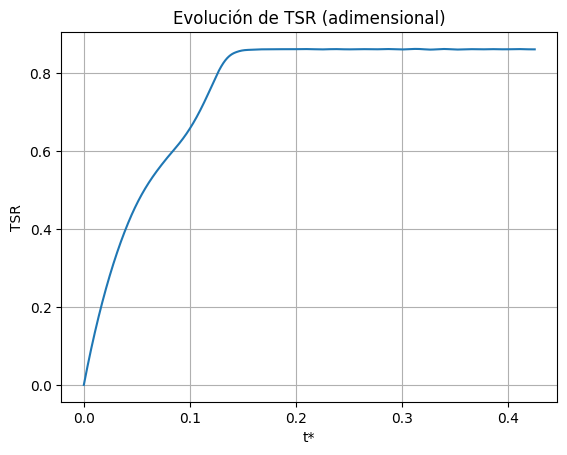

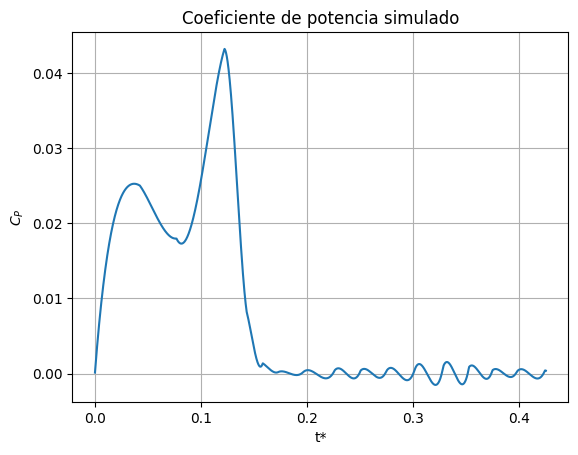

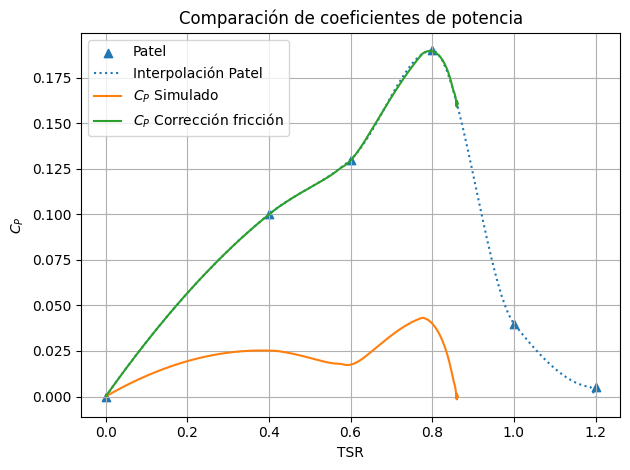

In [18]:
# -----------------------------
# Plots
# -----------------------------
plt.figure()
plt.plot(t_adim, TSR_t)
plt.xlabel("t*")
plt.ylabel("TSR")
plt.grid(True)
plt.title("Evolución de TSR (adimensional)")
plt.show()

plt.figure()
plt.plot(t_adim, Cp_t)
plt.xlabel("t*")
plt.ylabel("$C_P$")
plt.grid(True)
plt.title("Coeficiente de potencia simulado")
plt.show()

plt.figure()
plt.scatter(TSR_points, Cp_paper, marker='^', label='Patel')
plt.plot(xq, Cp(xq), ':', label='Interpolación Patel')
plt.plot(TSR_t, Cp_t, label='$C_P$ Simulado')
plt.plot(TSR_t, Cp_t_corregido, label='$C_P$ Corrección fricción')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel("TSR")
plt.ylabel("$C_P$")
plt.title("Comparación de coeficientes de potencia")
plt.tight_layout()
plt.show()
